# Predicting Heart Disease

## Score: .95043

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
#%pip install torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = Path("playground-series-s6e2")
OUTPUT_DIR = Path(".")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---- ----------------------------------- 13.6/113.8 MB 70.1 MB/s eta 0:00:02
   ------------ --------------------------- 34.9/113.8 MB 88.0 MB/s eta 0:00:01
   ------------------- -------------------- 54.3/113.8 MB 90.5 MB/s eta 0:00:01
   --------------------------- ------------ 78.1/113.8 MB 96.1 MB/s eta 0:00:01
   ---------------------------------- ---- 100.7/113.8 MB 98.9 MB/s eta 0:00:01
   -------------------------------------  113.5/113.8 MB 100.5 MB/s eta 0:00:01
   ---------------------------------------- 113.8/113.8 MB 89.7 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
train.head()

Train: (630000, 15)
Test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [17]:
target_col = "Heart Disease"
id_col = "id"
feature_cols = [c for c in train.columns if c not in (id_col, target_col)]

le = LabelEncoder()
y = le.fit_transform(train[target_col])

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

for col in feature_cols:
    if X_train[col].isna().any() or X_test[col].isna().any():
        med = X_train[col].median()
        X_train[col] = X_train[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

X_train["chol_exercise"] = X_train["Cholesterol"] * X_train["Exercise angina"]
X_test["chol_exercise"] = X_test["Cholesterol"] * X_test["Exercise angina"]
X_train["st_slope"] = X_train["ST depression"] * X_train["Slope of ST"]
X_test["st_slope"] = X_test["ST depression"] * X_test["Slope of ST"]
X_train["hr_age"] = X_train["Max HR"] * X_train["Age"]
X_test["hr_age"] = X_test["Max HR"] * X_test["Age"]
X_train["bp_age"] = X_train["BP"] * X_train["Age"]
X_test["bp_age"] = X_test["BP"] * X_test["Age"]

te_cols = ["Chest pain type", "Slope of ST", "Thallium"]
global_mean = float(y.mean())
m = 20
for col in te_cols:
    agg = pd.DataFrame({"_y": y}).groupby(X_train[col])["_y"].agg(["mean", "count"])
    smoothed = (agg["count"] * agg["mean"] + m * global_mean) / (agg["count"] + m)
    X_train[col + "_te"] = X_train[col].map(smoothed).fillna(global_mean)
    X_test[col + "_te"] = X_test[col].map(smoothed).fillna(global_mean)

scaler_feat = StandardScaler()
X_tr_s = scaler_feat.fit_transform(X_train)
X_te_s = scaler_feat.transform(X_test)
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
kmeans.fit(X_tr_s)
for i in range(kmeans.n_clusters):
    d_tr = np.linalg.norm(X_tr_s - kmeans.cluster_centers_[i], axis=1)
    d_te = np.linalg.norm(X_te_s - kmeans.cluster_centers_[i], axis=1)
    X_train[f"dist_c{i}"] = d_tr
    X_test[f"dist_c{i}"] = d_te

print(f"Features: {len(X_train.columns)} columns")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

Features: 32 columns
Target distribution: {0: 347546, 1: 282454}


In [18]:
param_grid = {"depth": [4, 5, 6], "lr": [0.03, 0.04, 0.05], "min_data_in_leaf": [15, 25, 35]}
n_est = 800
best_auc, best_params = 0, None
for depth in param_grid["depth"]:
    for lr in param_grid["lr"]:
        for min_leaf in param_grid["min_data_in_leaf"]:
            m = cb.CatBoostClassifier(iterations=n_est, depth=depth, learning_rate=lr, min_data_in_leaf=min_leaf, subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
            oof = cross_val_predict(m, X_train, y, cv=cv, method="predict_proba")[:, 1]
            auc = roc_auc_score(y, oof)
            if auc > best_auc:
                best_auc, best_params = auc, {"depth": depth, "lr": lr, "min_data_in_leaf": min_leaf}
print(f"Best OOF AUC: {best_auc:.5f}, params: {best_params}")

Best OOF AUC: 0.95507, params: {'depth': 6, 'lr': 0.05, 'min_data_in_leaf': 15}


In [19]:
model = cb.CatBoostClassifier(iterations=n_est, depth=best_params["depth"], learning_rate=best_params["lr"], min_data_in_leaf=best_params["min_data_in_leaf"], subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
oof_cb = cross_val_predict(model, X_train, y, cv=cv, method="predict_proba")[:, 1]
xgb_model = xgb.XGBClassifier(n_estimators=n_est, max_depth=5, learning_rate=0.05, min_child_weight=20, subsample=0.75, colsample_bytree=0.75, random_state=42, eval_metric="auc")
oof_xgb = cross_val_predict(xgb_model, X_train, y, cv=cv, method="predict_proba")[:, 1]
best_w, best_auc = 0.0, roc_auc_score(y, oof_cb)
for w in [0, 0.1, 0.2, 0.3, 0.4]:
    oof_blend = (1 - w) * oof_cb + w * oof_xgb
    auc = roc_auc_score(y, oof_blend)
    if auc > best_auc:
        best_auc, best_w = auc, w
oof = (1 - best_w) * oof_cb + best_w * oof_xgb
print(f"CV AUC: {best_auc:.5f} (blend w_xgb={best_w})")

CV AUC: 0.95517 (blend w_xgb=0.4)


In [20]:
model.fit(X_train, y)
xgb_model.fit(X_train, y)
test_cb = model.predict_proba(X_test)[:, 1]
test_xgb = xgb_model.predict_proba(X_test)[:, 1]
test_proba = (1 - best_w) * test_cb + best_w * test_xgb

In [21]:
X_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_np = y.astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class TabDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.y is None:
            return torch.from_numpy(x)
        return torch.from_numpy(x), torch.tensor(self.y[idx])


class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


def train_one_fold(X_tr, y_tr, X_val, y_val, epochs=25, batch_size=4096, lr=1e-3):
    ds_tr = TabDataset(X_tr, y_tr)
    ds_val = TabDataset(X_val, y_val)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=0)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)

    model = MLP(X_tr.shape[1]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    criterion = nn.BCEWithLogitsLoss()

    best_auc, best_state = 0.0, None
    for epoch in range(epochs):
        model.train()
        for xb, yb in dl_tr:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
        scheduler.step()

        model.eval()
        val_preds = []
        with torch.no_grad():
            for xb, yb in dl_val:
                xb = xb.to(device)
                logits = model(xb)
                probs = torch.sigmoid(logits).cpu().numpy()
                val_preds.append(probs)
        val_preds = np.concatenate(val_preds)
        auc = roc_auc_score(y_val, val_preds)
        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_auc


oof_nn = np.zeros(len(y_np), dtype=np.float32)
test_preds_folds = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_np, y_np)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_tr, y_tr = X_np[tr_idx], y_np[tr_idx]
    X_val, y_val = X_np[val_idx], y_np[val_idx]
    model_f, best_auc_fold = train_one_fold(X_tr, y_tr, X_val, y_val)
    print(f"  Best fold AUC: {best_auc_fold:.5f}")

    ds_val = TabDataset(X_val, y_val)
    dl_val = DataLoader(ds_val, batch_size=4096, shuffle=False, num_workers=0)
    model_f.eval()
    preds_val = []
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device)
            logits = model_f(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds_val.append(probs)
    oof_nn[val_idx] = np.concatenate(preds_val)

    ds_test = TabDataset(X_test_np, None)
    dl_test = DataLoader(ds_test, batch_size=4096, shuffle=False, num_workers=0)
    test_fold = []
    with torch.no_grad():
        for xb in dl_test:
            xb = xb.to(device)
            logits = model_f(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            test_fold.append(probs)
    test_preds_folds.append(np.concatenate(test_fold))


test_proba_nn = np.mean(np.stack(test_preds_folds, axis=0), axis=0)
auc_nn = roc_auc_score(y_np, oof_nn)
print(f"Neural net CV AUC: {auc_nn:.5f}")

oof = oof_nn
test_proba = test_proba_nn

Using device: cpu
Fold 1/5
  Best fold AUC: 0.95285
Fold 2/5
  Best fold AUC: 0.95204
Fold 3/5
  Best fold AUC: 0.95284
Fold 4/5
  Best fold AUC: 0.95228
Fold 5/5
  Best fold AUC: 0.95279
Neural net CV AUC: 0.95253


Confusion matrix (OOF, threshold=0.5)
Rows: true, Cols: predicted |  Absence   Presence
[[314316  33230]
 [ 39126 243328]]


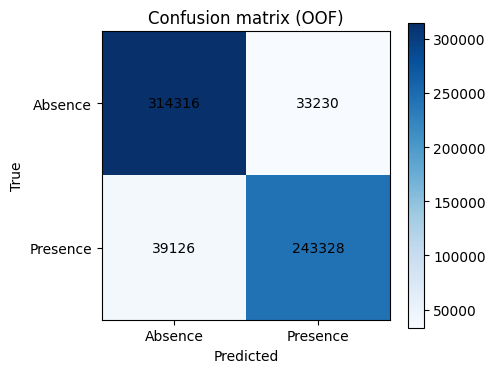

In [22]:
y_pred = (oof >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)
print("Confusion matrix (OOF, threshold=0.5)")
print("Rows: true, Cols: predicted |  Absence   Presence")
print(cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Absence", "Presence"])
plt.yticks([0, 1], ["Absence", "Presence"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.title("Confusion matrix (OOF)")
plt.tight_layout()
plt.show()

In [23]:
sub = pd.DataFrame({"id": test["id"], "Heart Disease": test_proba})
sub.to_csv(OUTPUT_DIR / "submission.csv", index=False)
print(f"Submission saved to {OUTPUT_DIR / 'submission.csv'}")
sub.head(10)

Submission saved to submission.csv


,id,Heart Disease
0,630000,0.960252
1,630001,0.003412
2,630002,0.991019
3,630003,0.005729
4,630004,0.224402
5,630005,0.991706
6,630006,0.016263
7,630007,0.677635
8,630008,0.994683
9,630009,0.012875
